In [1]:
import os, sys
import pandas as pd
import numpy as np
import collections, itertools
from scipy.stats import gaussian_kde

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
import seaborn as sns
plt.rcParams['figure.dpi'] = 300


In [2]:
from scipy.stats import poisson

In [3]:
poisson.cdf(15, 0.0001*100_000)

0.9512595966960213

In [20]:
np.power(10, np.arange(0, 8, 0.5)).round()

array([1.0000000e+00, 3.0000000e+00, 1.0000000e+01, 3.2000000e+01,
       1.0000000e+02, 3.1600000e+02, 1.0000000e+03, 3.1620000e+03,
       1.0000000e+04, 3.1623000e+04, 1.0000000e+05, 3.1622800e+05,
       1.0000000e+06, 3.1622780e+06, 1.0000000e+07, 3.1622777e+07])

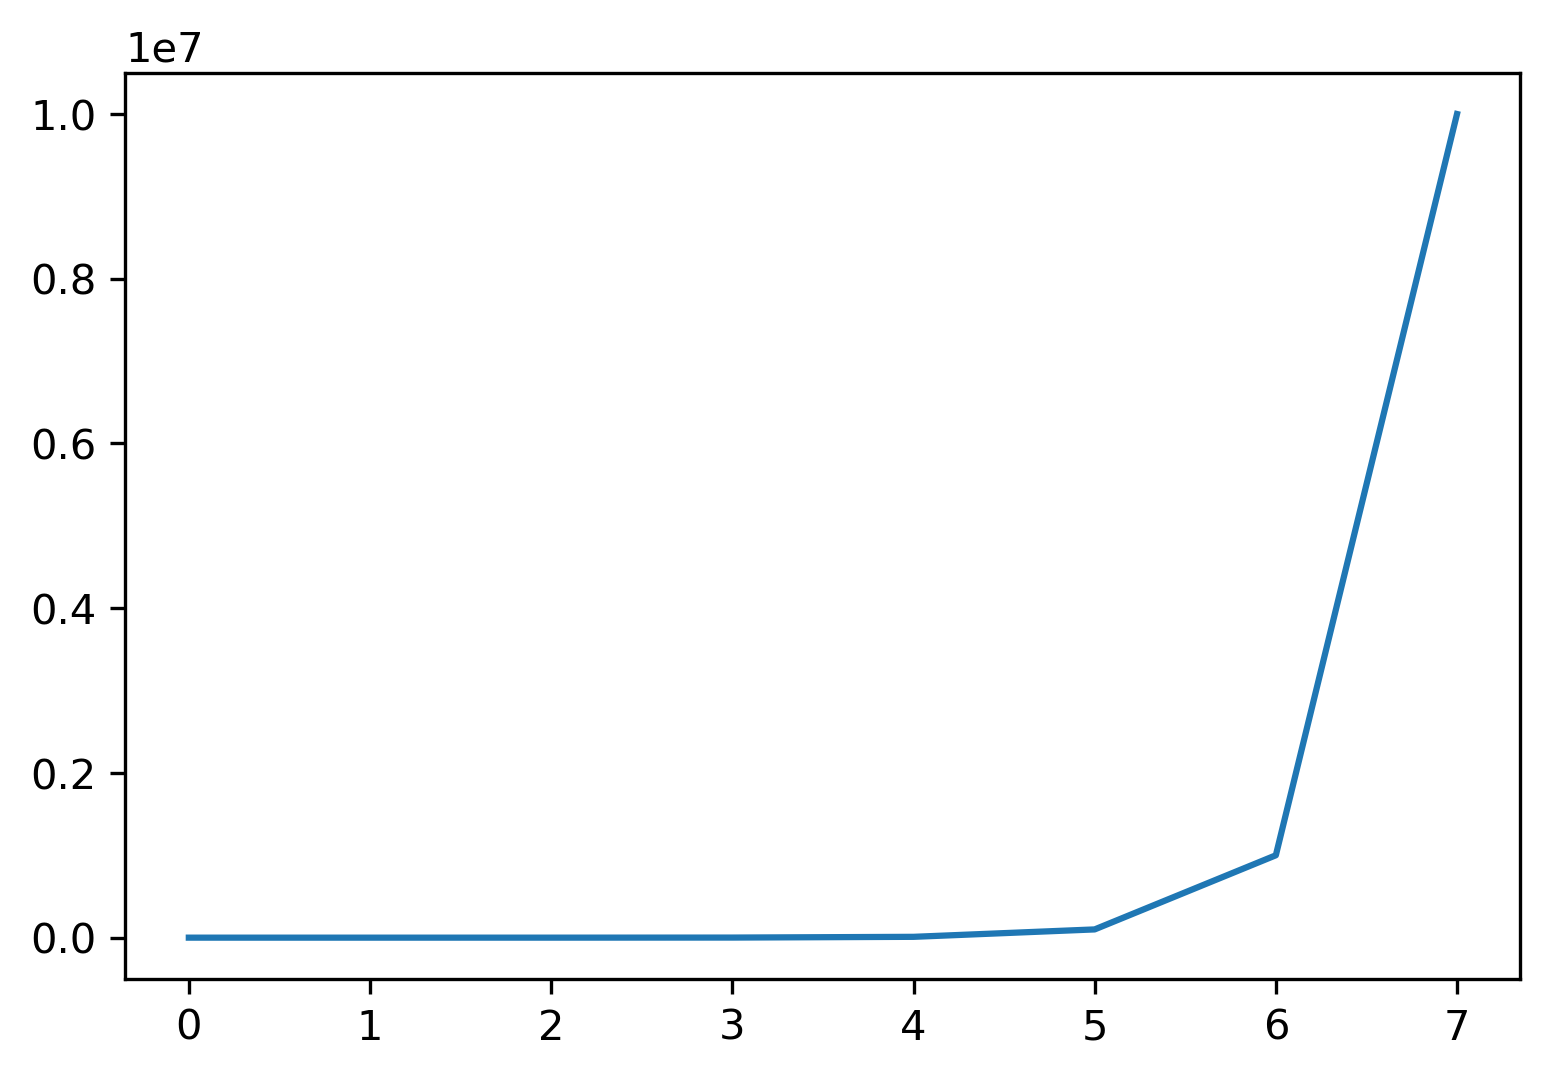

In [17]:
plt.plot(np.power(10, np.arange(0, 8, 1)))

In [25]:
ANs[-2]

63095734.0

In [46]:
np.power(10, np.arange(-0.5, -6.5, -0.5))

array([3.16227766e-01, 1.00000000e-01, 3.16227766e-02, 1.00000000e-02,
       3.16227766e-03, 1.00000000e-03, 3.16227766e-04, 1.00000000e-04,
       3.16227766e-05, 1.00000000e-05, 3.16227766e-06, 1.00000000e-06])

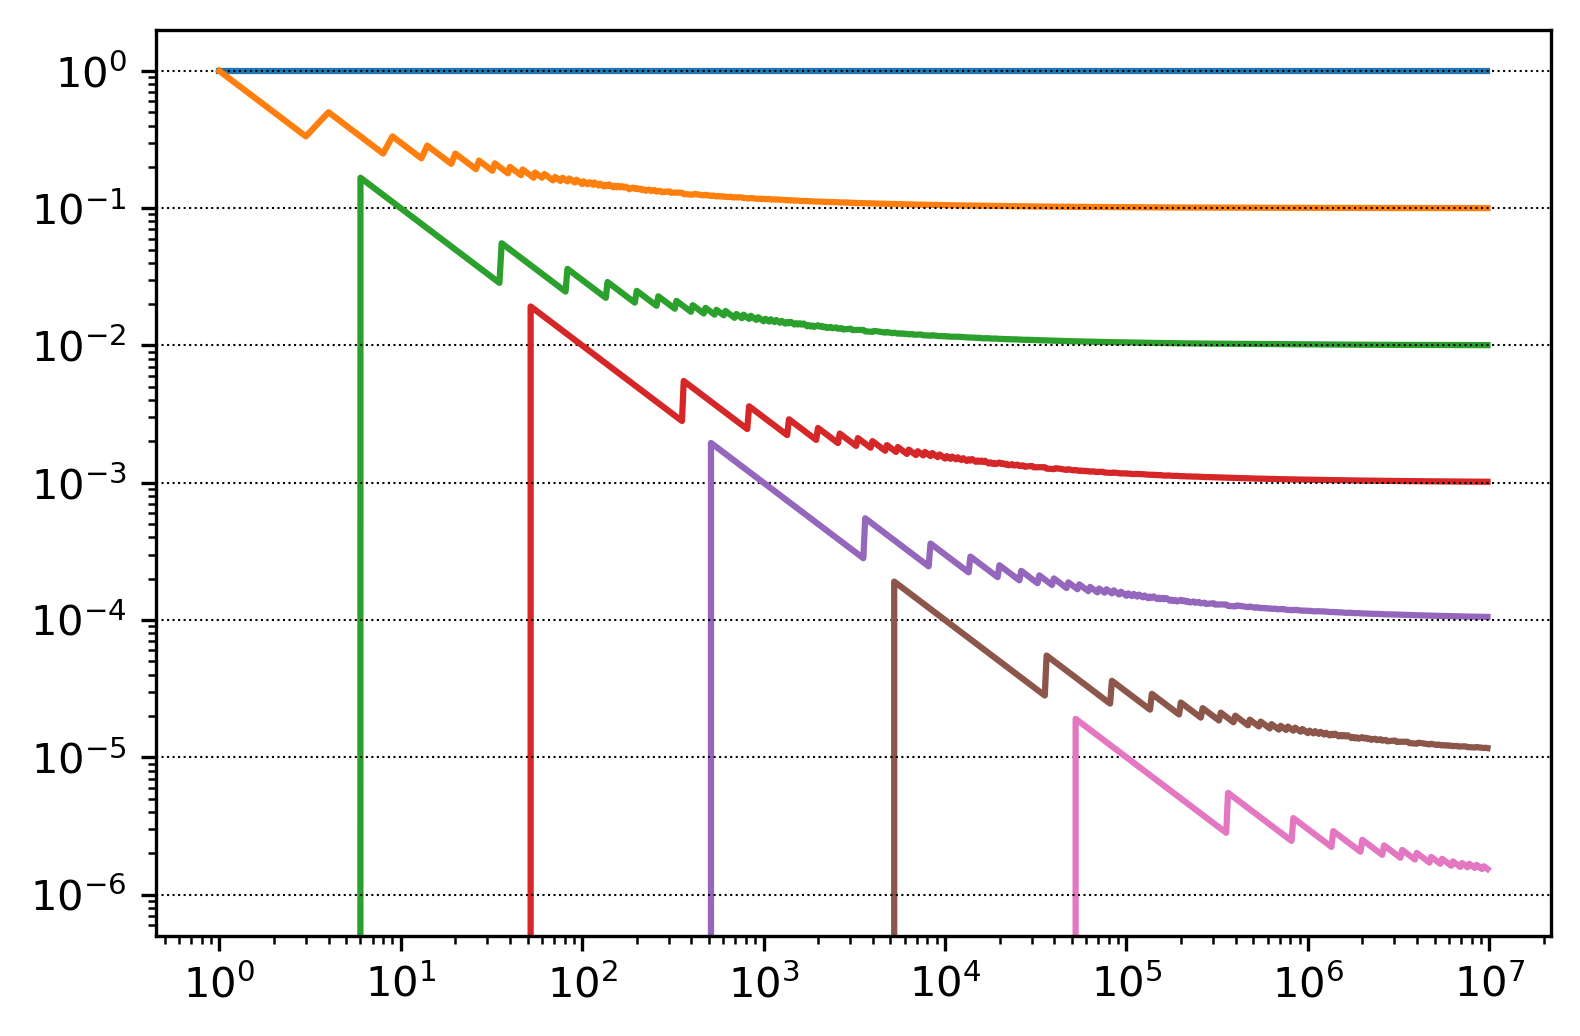

In [56]:
AFs = np.power(10, np.arange(0, -7, -1.0))
ANs = np.power(10, np.arange(0, 7, 0.01)).round()
for AF in AFs:
    plt.plot(ANs, np.minimum(1, poisson.ppf(0.95, AF*ANs)/ANs))
    plt.axhline(AF, ls='dotted', c='k', lw=0.5)
plt.xscale('log')
plt.yscale('log')

In [61]:
ACs = np.power(10,np.arange(0, 3.2, 0.2)).round()
ANs = np.power(10,np.arange(1, 7, 0.1)).round()

In [62]:
def 

array([   1.,    2.,    3.,    4.,    6.,   10.,   16.,   25.,   40.,
         63.,  100.,  158.,  251.,  398.,  631., 1000.])

In [2]:
def read_gene_spec_sum(path):
    return pd.read_table(path, 
                      sep='\t', 
                      index_col=False, 
                      skiprows=1, 
                      na_values='-')\
        .rename(columns={
            '#Symbol': 'symbol',
            'GeneID': 'gene_id',
            'Total_submissions': 'n_submissions',
            'Total_alleles': 'n_alleles',
            'Submissions_reporting_this_gene': 'n_gene_submissions',
            'Alleles_reported_Pathogenic_Likely_pathogenic': 'n_plp',
            'Gene_MIM_number': 'mim_id',
            'Number_uncertain': 'n_vus',
            'Number_with_conflicts': 'n_conflicts'
        })

def read_var_sum(path):
    return pd.read_parquet(path)

In [6]:
genes = read_gene_spec_sum('data/gene_specific_summary.txt')
ppi = pd.read_table('data/STRING.protein.physical.full.txt', sep=' ')
pinfo = pd.read_table('data/9606.protein.info.v11.5.txt', sep='\t')
genes = genes.merge(pinfo, left_on = 'symbol', right_on="preferred_name", how='left')

ppi = ppi.merge(pinfo[['#string_protein_id', 'preferred_name']].add_suffix('1'), 
                  left_on='protein1', 
                  right_on='#string_protein_id1', 
                  how='left')\
        .merge(pinfo[['#string_protein_id', 'preferred_name']].add_suffix('2'), 
                  left_on='protein2', 
                  right_on='#string_protein_id2', 
                  how='left')
ppi = ppi.drop(columns=['#string_protein_id1', '#string_protein_id2'])

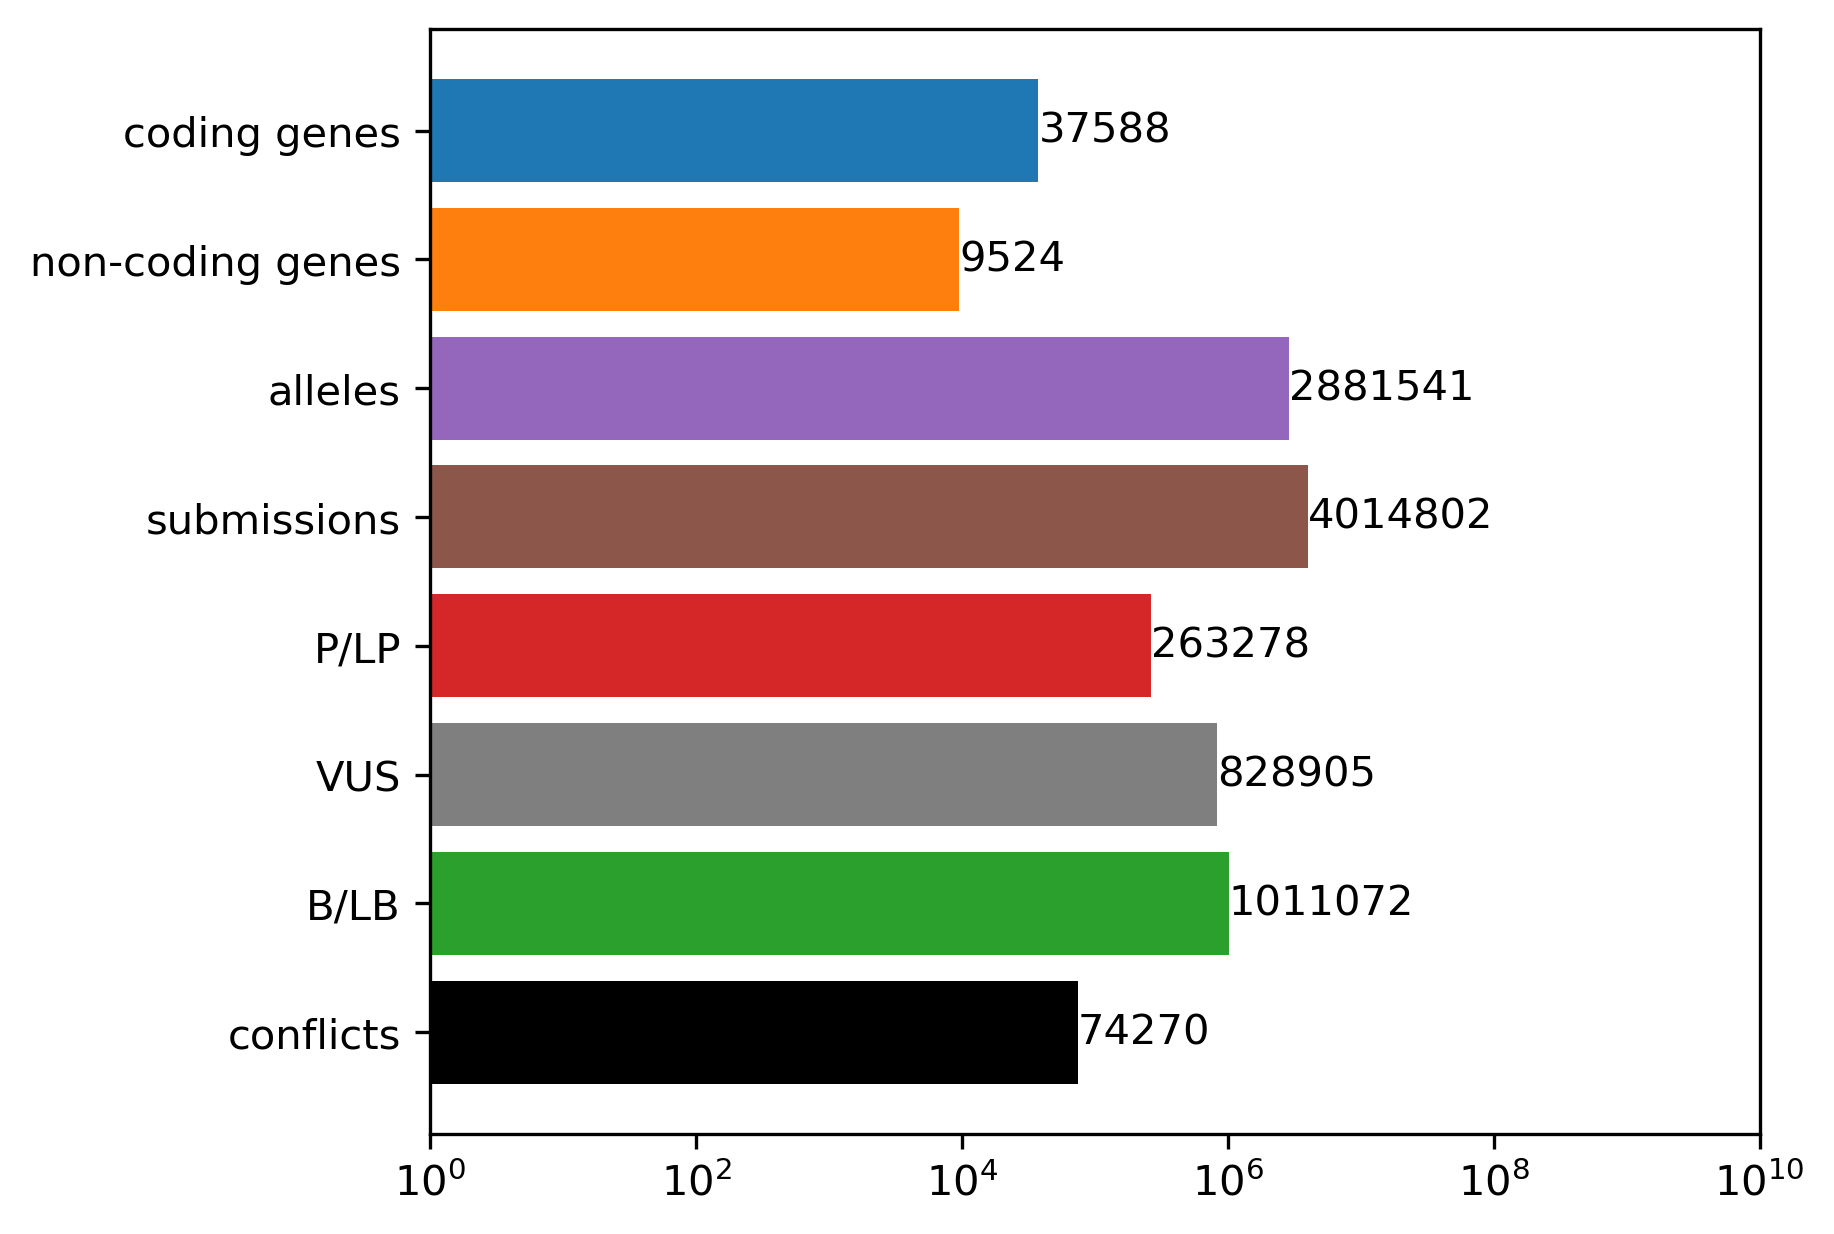

In [7]:
fig, ax = plt.subplots(1,1, 
                       figsize=(6,4), 
                       constrained_layout=True)

labels = [
    'coding genes', 
    'non-coding genes', 
    'alleles', 
    'submissions', 
    'P/LP', 
    'VUS', 
    'B/LB', 
    'conflicts'
]
genes['n_blb'] = genes['n_alleles'] - genes['n_plp'] - genes['n_vus'] - genes['n_conflicts']
counts = [
    len(genes),
    genes.symbol.str.contains('^LOC\d+').sum(),
    genes['n_alleles'].sum(),
    genes['n_submissions'].sum(),
    genes['n_plp'].sum(),
    genes['n_vus'].sum(),
    genes['n_blb'].sum(),
    genes['n_conflicts'].sum()
]

plt.barh(
    y = labels, 
    width = counts, 
    color = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:red', 'tab:grey', 'tab:green', 'black']
)
for idx,c in enumerate(counts):
    plt.text(x = c, y=idx, s=str(int(c)), va = 'center')
plt.xscale('log')
plt.xlim([1, 10e9])
plt.gca().invert_yaxis()


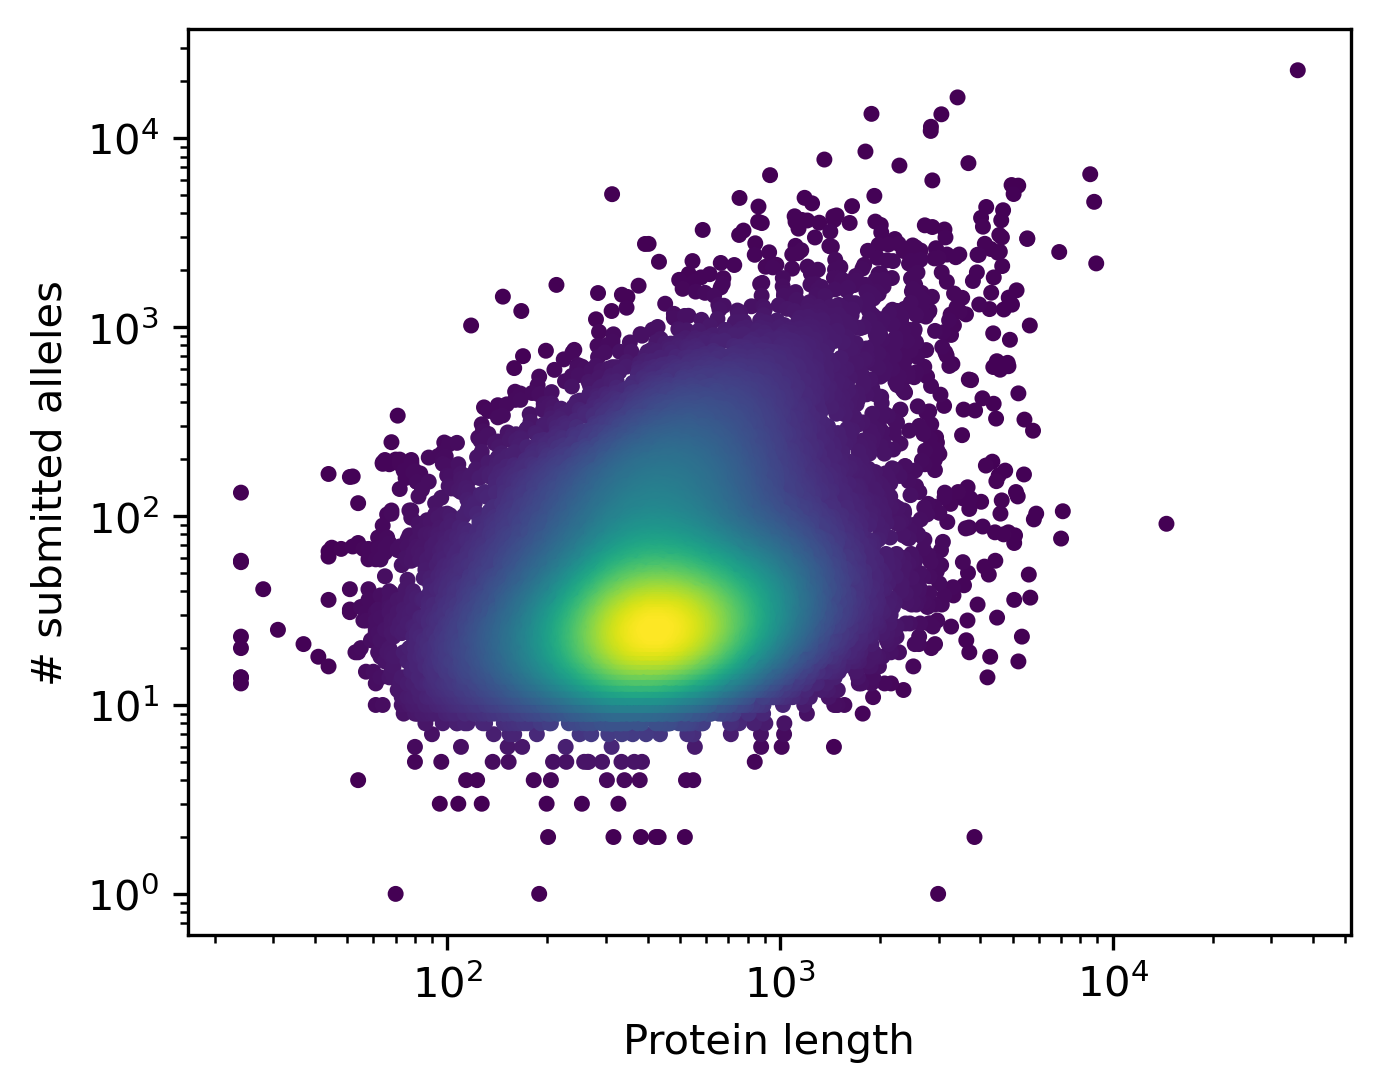

In [8]:
xy = genes[['protein_size', 'n_alleles']].dropna(axis = 0, how='any').values.T
z = gaussian_kde(np.log(xy), bw_method=0.35)(np.log(xy))
sort_idx = z.argsort()

fig, ax = plt.subplots(1,1,figsize=(5,4))
ax.scatter(xy[0, sort_idx], xy[1, sort_idx], alpha = 1, c=z[sort_idx], s=8)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Protein length')
ax.set_ylabel('# submitted alleles');

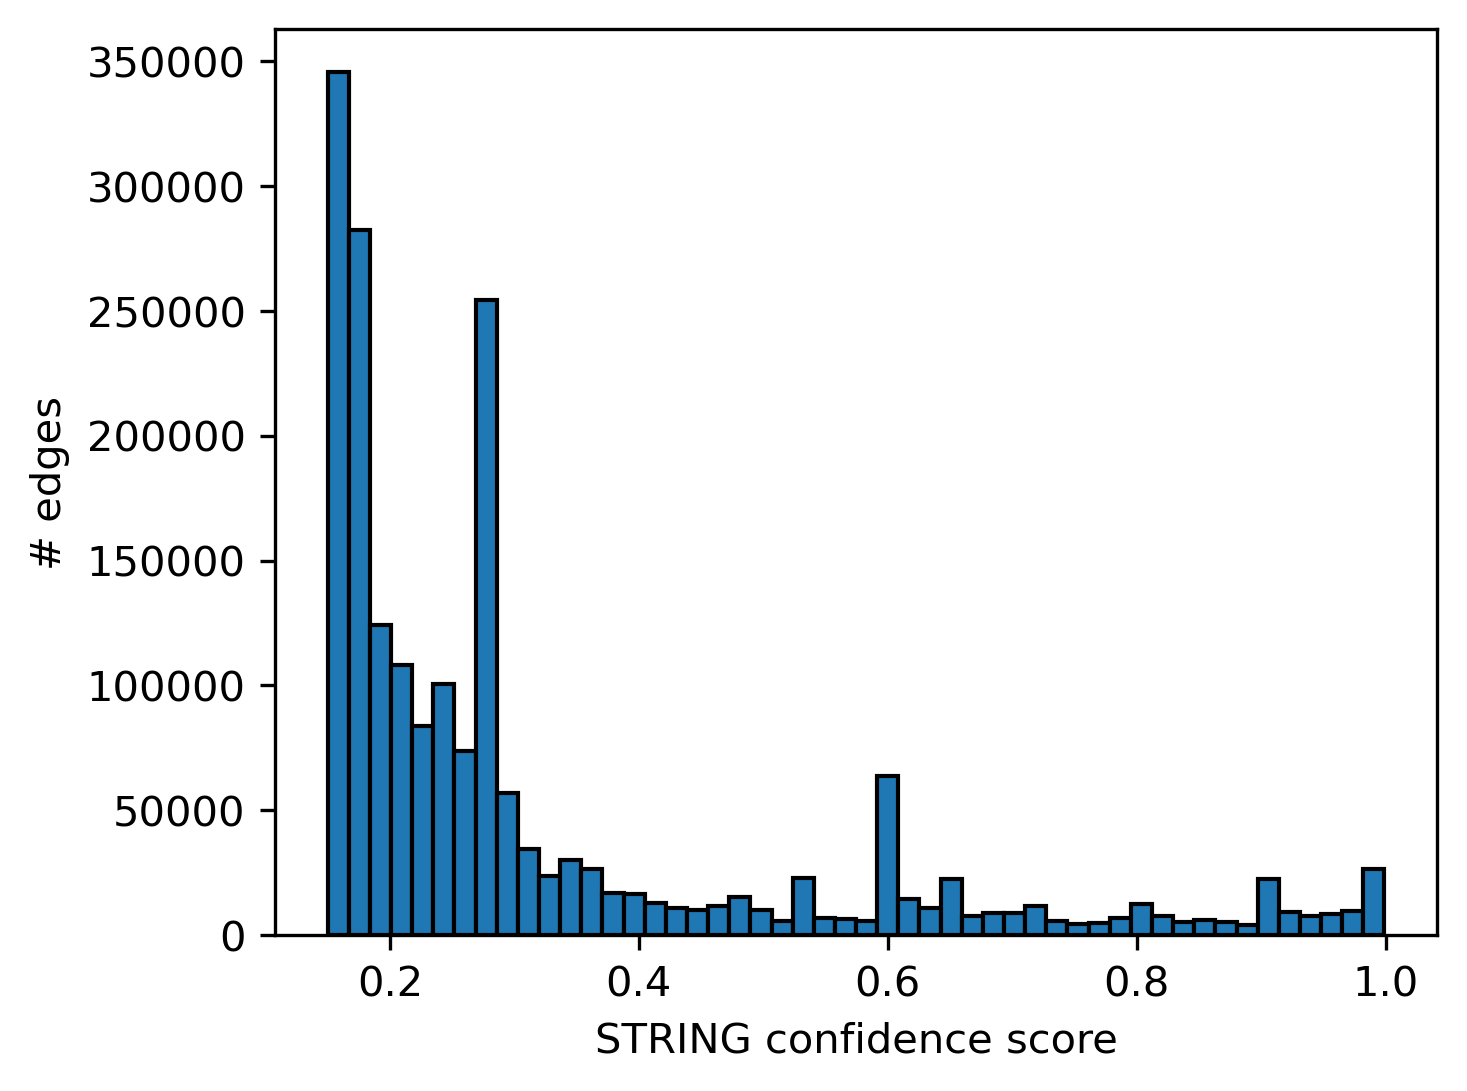

In [9]:
fig, ax = plt.subplots(1,1,figsize = (5,4))
ax.hist(ppi.combined_score/1000, bins = 50, edgecolor='k');
ax.set_xlabel('STRING confidence score')
ax.set_ylabel('# edges');

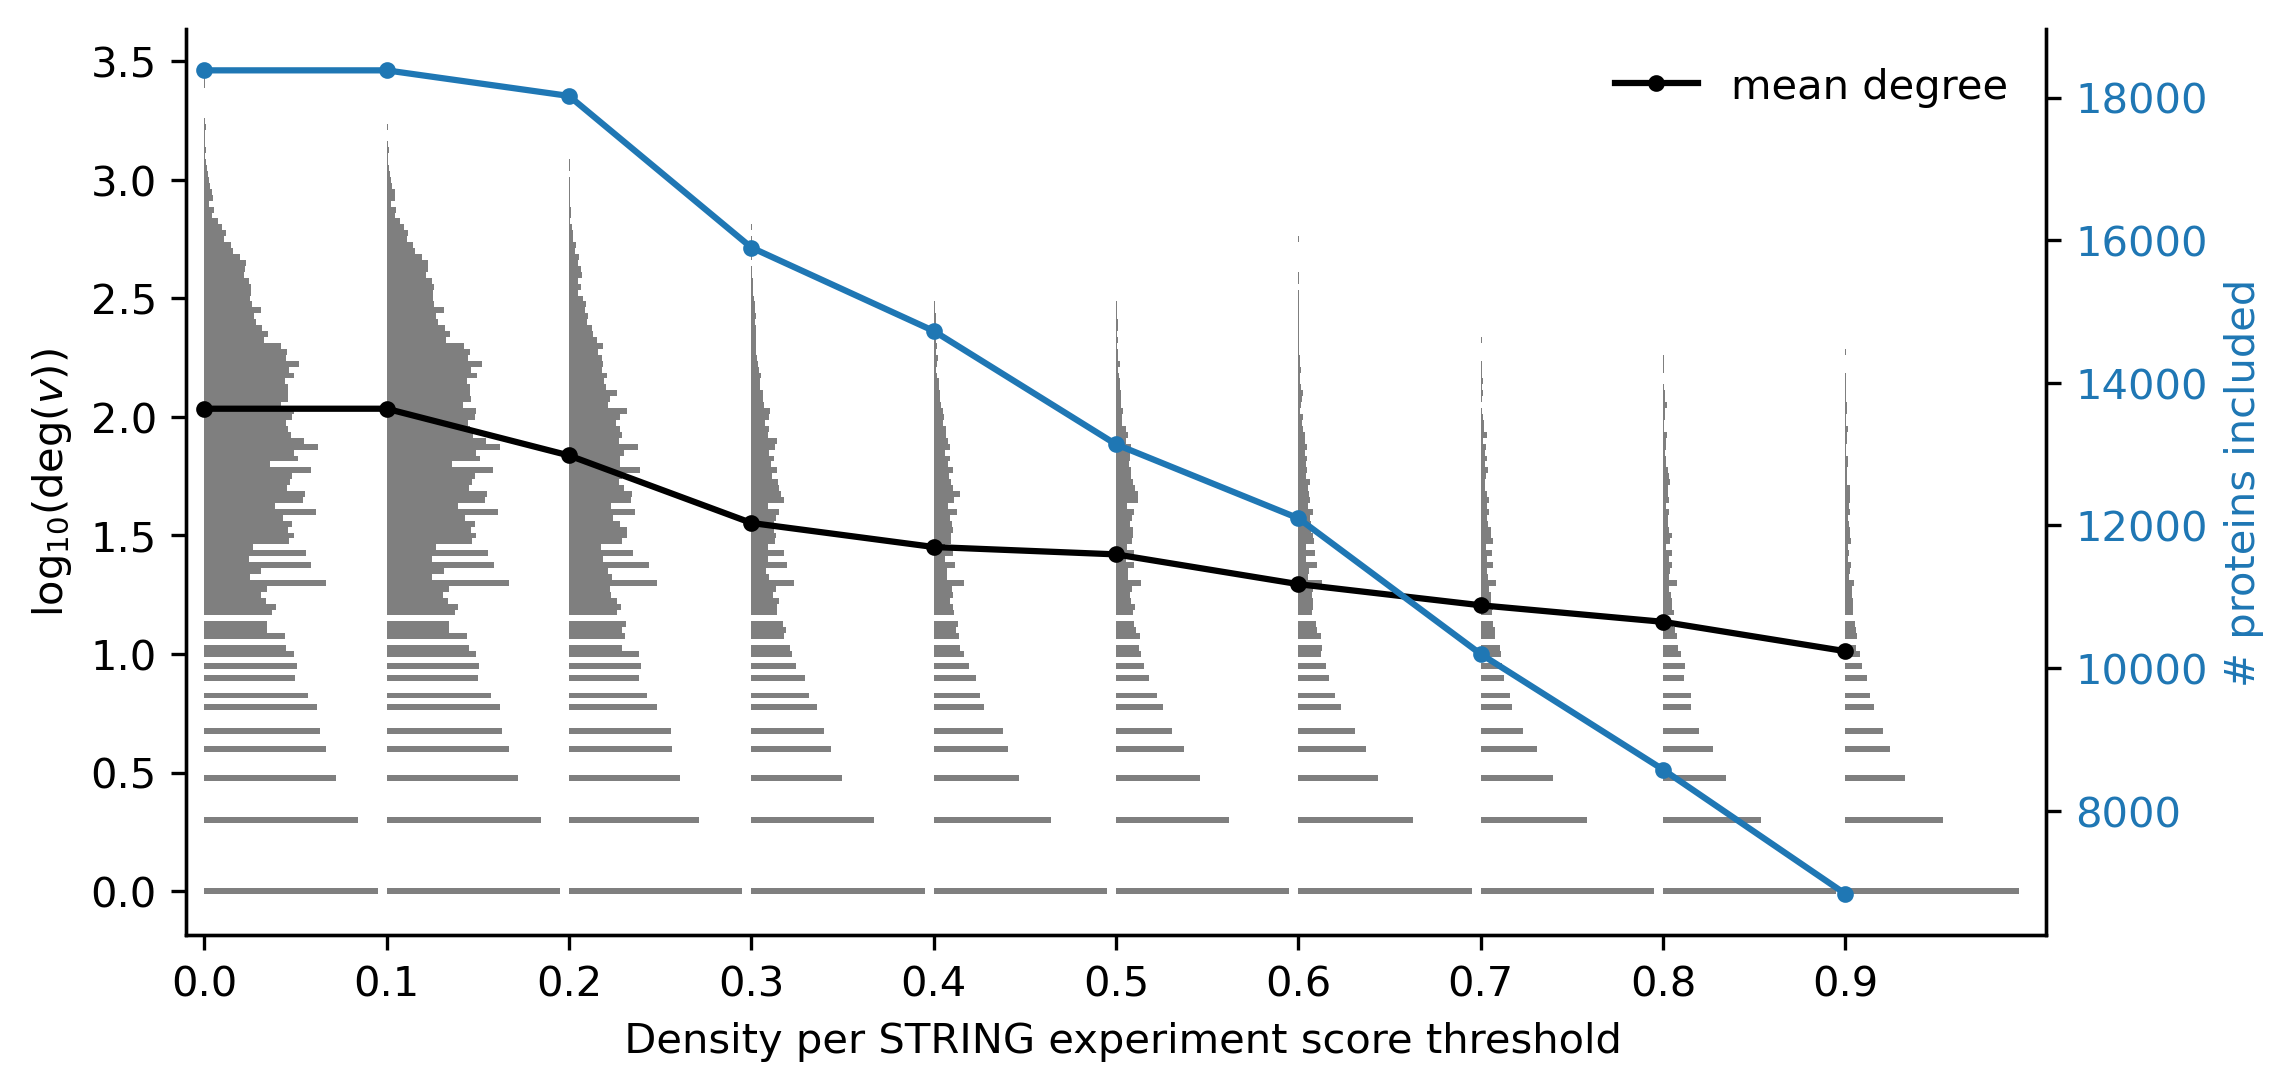

In [10]:
fig, ax = plt.subplots(1,1,figsize=(8, 4))

num_prots = []
avg_deg = []
step = 100
scores = np.arange(0, 1000, step)
for score_thresh in scores:
    degrees = ppi[ppi.combined_score > score_thresh]['preferred_name1'].value_counts()
    avg_deg.append(np.log10(degrees.mean()))
    num_prots.append(len(degrees))
    counts, bins = np.histogram(np.log10(degrees), bins = np.arange(0, 3.5, 0.025))
    counts = counts/counts.sum()
    max_count = counts.max()
    ax.barh(y = bins[:-1], width = counts/counts.max() * 0.95 * step, height=0.025, left = score_thresh, color='tab:grey')

ax.plot(scores, avg_deg, marker='o', markersize=3, c='k')
ax.legend([Line2D([0], [0], color='k', marker='o', markersize=3)], ['mean degree'], frameon=False)
ax2 = ax.twinx()
ax2.plot(scores, num_prots, marker='o', markersize=3)
ax2.set_ylabel('# proteins included', color='tab:blue')
ax2.tick_params(axis="y", labelcolor='tab:blue')

ax.set_xticks(scores)
ax.set_xticklabels(scores/1000)
ax.set_xlim(-10, 1010)
ax.set_xlabel(' Density per STRING experiment score threshold')
ax.set_ylabel(r'$\log_{10}(\mathrm{deg}(v))$')
ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False);

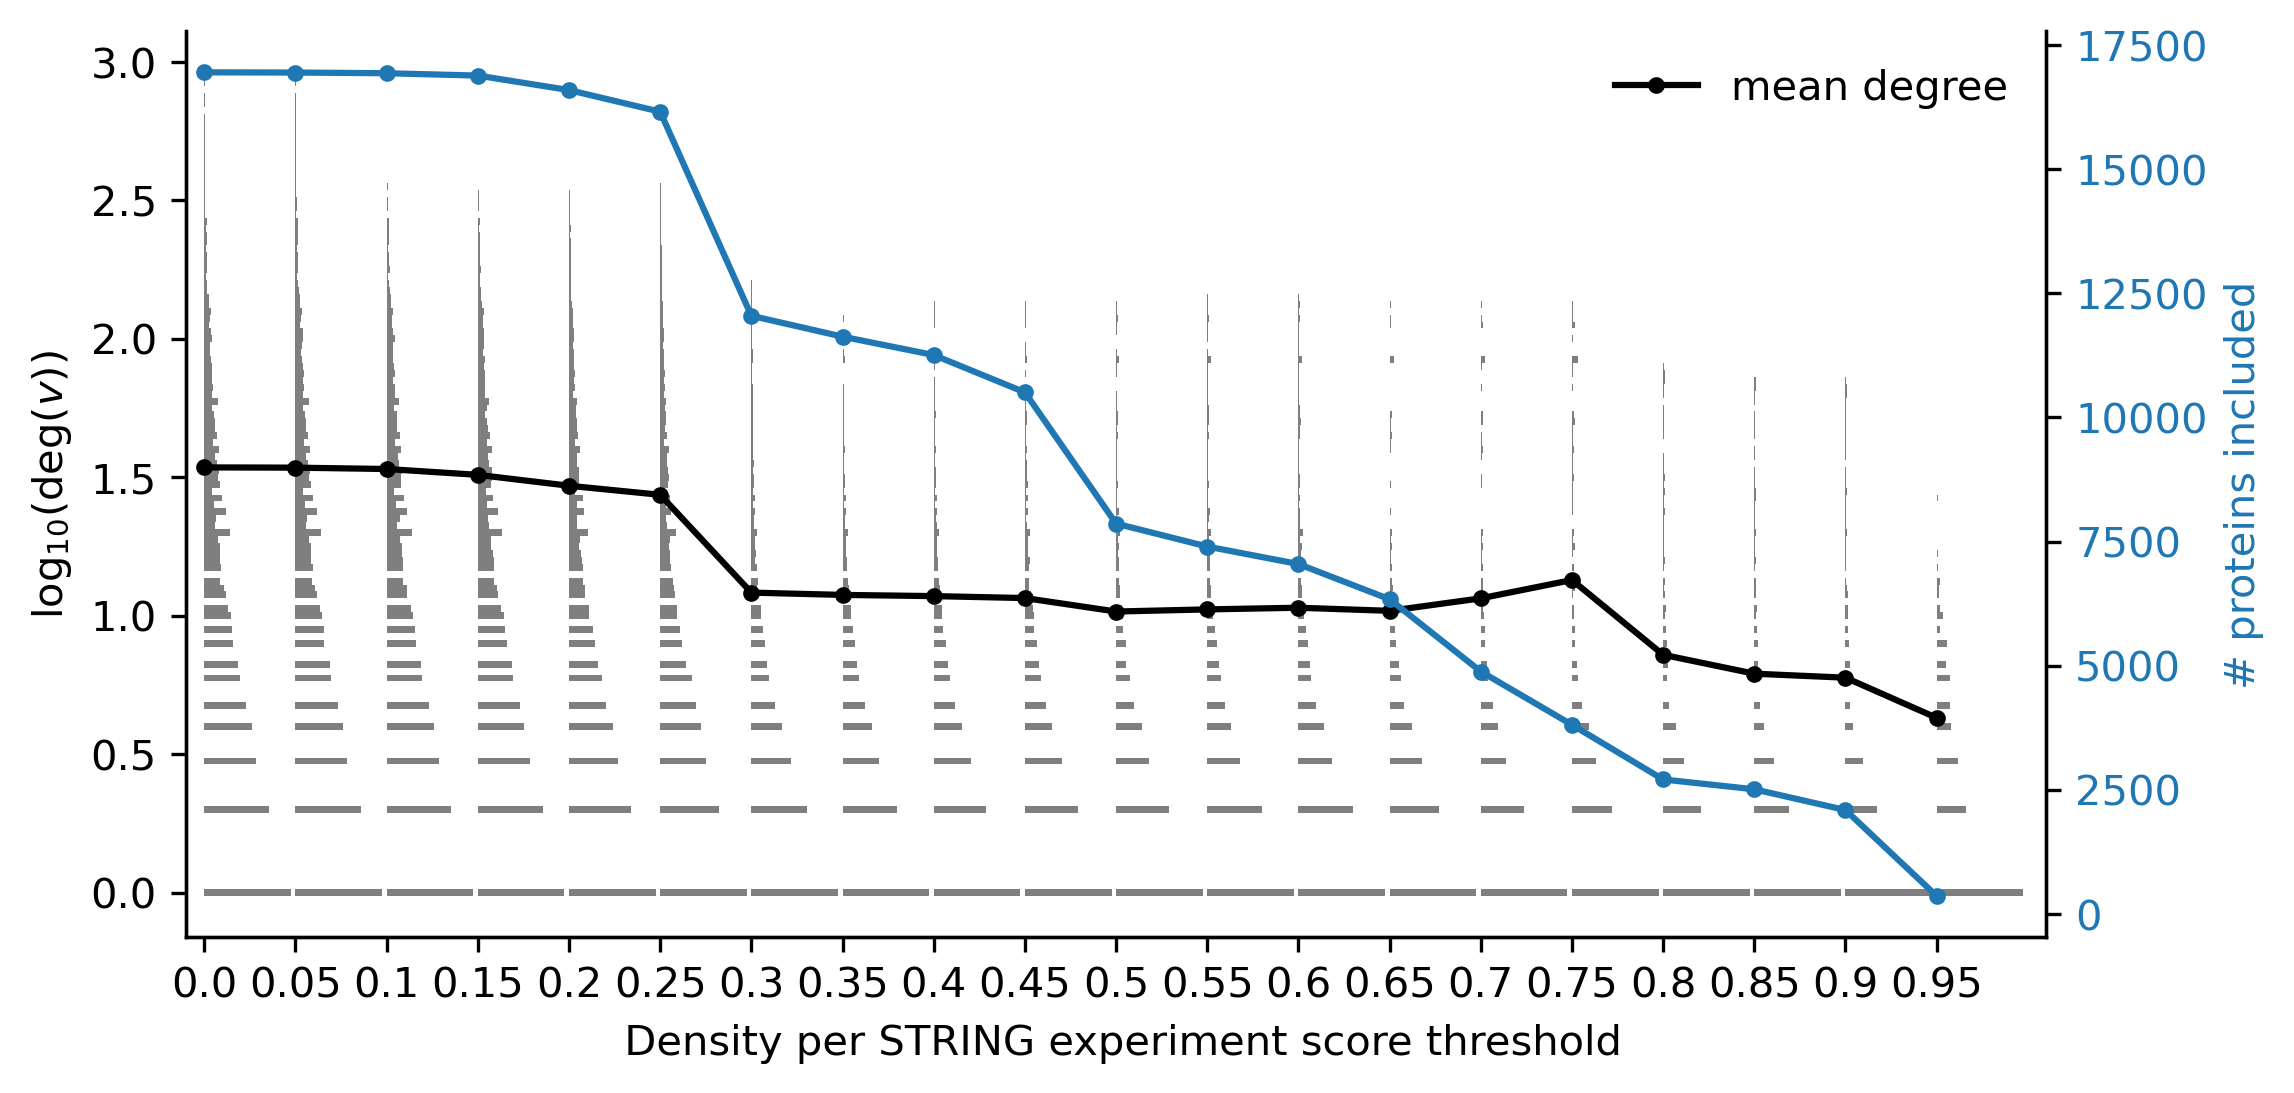

In [11]:
fig, ax = plt.subplots(1,1,figsize=(8, 4))

num_prots = []
avg_deg = []
step = 50
scores = np.arange(0, 1000, step)
for score_thresh in scores:
    degrees = ppi[ppi.experiments > score_thresh]['preferred_name1'].value_counts()
    avg_deg.append(np.log10(degrees.mean()))
    num_prots.append(len(degrees))
    counts, bins = np.histogram(np.log10(degrees), bins = np.arange(0, 3, 0.025))
    counts = counts/counts.sum()
    max_count = counts.max()
    ax.barh(y = bins[:-1], width = counts/counts.max() * 0.95 * step, height=0.025, left = score_thresh, color='tab:grey')

ax.plot(scores, avg_deg, marker='o', markersize=3, c='k')
ax.legend([Line2D([0], [0], color='k', marker='o', markersize=3)], ['mean degree'], frameon=False)
ax2 = ax.twinx()
ax2.plot(scores, num_prots, marker='o', markersize=3)
ax2.set_ylabel('# proteins included', color='tab:blue')
ax2.tick_params(axis="y", labelcolor='tab:blue')

ax.set_xticks(scores)
ax.set_xticklabels(scores/1000)
ax.set_xlim(-10, 1010)
ax.set_xlabel(' Density per STRING experiment score threshold')
ax.set_ylabel(r'$\log_{10}(\mathrm{deg}(v))$')
ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False);

In [121]:
degrees = ppi[ppi.experiments > 600]['preferred_name1'].value_counts().to_frame(name='degrees600')
genes = genes.merge(degrees, left_on = 'preferred_name', right_index=True, how='left')

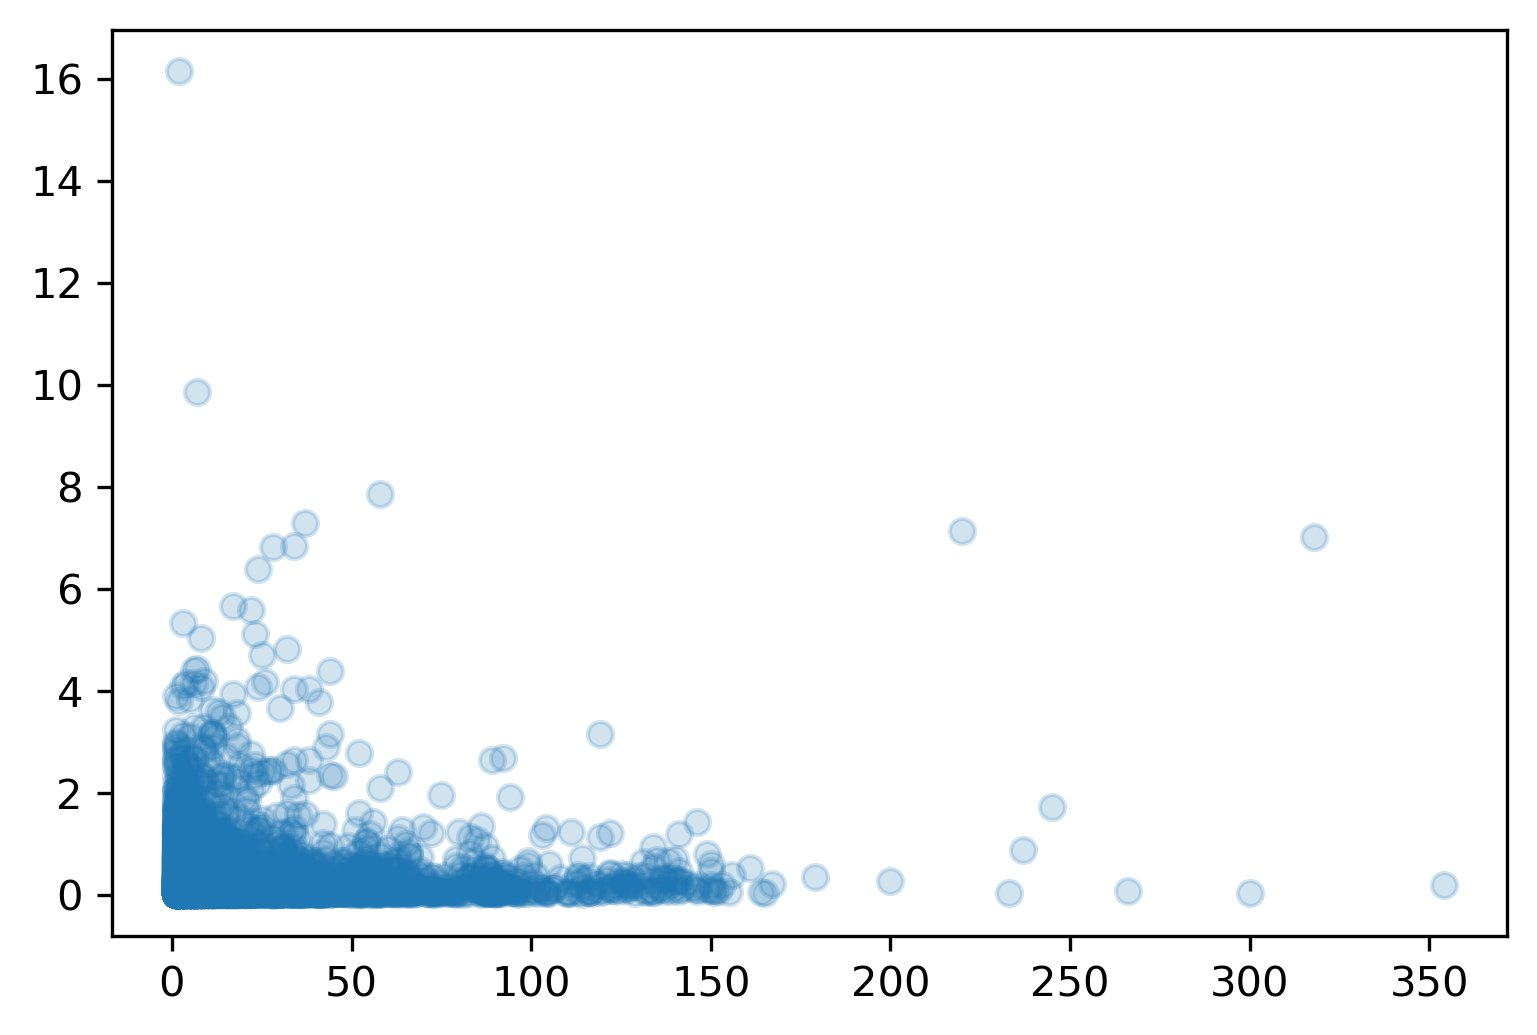

In [122]:
plt.scatter(genes['degrees500'], genes['n_alleles']/genes['protein_size'], alpha = 0.2)

# plt.xscale('log')
# plt.yscale('log')

In [4]:
vsum = read_var_sum('data/variant_summary_GRCh38.parquet')

In [12]:
vsum_pheno = vsum[~vsum["PhenotypeList"].isna()]

In [13]:
vsum

,AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),...,ReviewStatus,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,Ref,Alt
1,15041,Indel,NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTA...,9907,AP5Z1,HGNC:22197,Pathogenic,1,NaT,397704705,...,"criteria provided, single submitter",2,NaN,0,"ClinGen:CA215070,OMIM:613653.0001",3,2,4781213,GGAT,TGCTGTAAACTGTAACTGTAAA
3,15042,Deletion,NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs),9907,AP5Z1,HGNC:22197,Pathogenic,1,2010-06-29,397704709,...,no assertion criteria provided,1,NaN,0,"ClinGen:CA215072,OMIM:613653.0002",1,3,4787729,GCTGCTGGACCTGCC,G
5,15043,single nucleotide variant,NM_014630.3(ZNF592):c.3136G>A (p.Gly1046Arg),9640,ZNF592,HGNC:28986,Uncertain significance,0,2015-06-29,150829393,...,no assertion criteria provided,1,NaN,0,"OMIM:613624.0001,ClinGen:CA210674,UniProtKB:Q9...",1,4,84799209,G,A
7,15044,single nucleotide variant,NM_017547.4(FOXRED1):c.694C>T (p.Gln232Ter),55572,FOXRED1,HGNC:26927,Pathogenic,1,2022-06-28,267606829,...,"criteria provided, multiple submitters, no con...",5,NaN,0,"ClinGen:CA113792,OMIM:613622.0001",3,5,126275389,C,T
9,15045,single nucleotide variant,NM_017547.4(FOXRED1):c.1289A>G (p.Asn430Ser),55572,FOXRED1,HGNC:26927,Pathogenic,1,2010-10-01,267606830,...,no assertion criteria provided,1,NaN,0,"ClinGen:CA113794,UniProtKB:Q96CU9#VAR_064571,O...",1,6,126277517,A,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4324854,2403613,single nucleotide variant,NM_001349338.3(FOXP1):c.1280C>T (p.Thr427Ile),27086,FOXP1,HGNC:3823,Uncertain significance,0,2020-08-24,-1,...,"criteria provided, single submitter",1,NaN,0,None,2,2430110,70977896,G,A
4324856,2403614,single nucleotide variant,NM_001256012.3(MYH10):c.3364G>T (p.Glu1122Ter),4628,MYH10,HGNC:7568,Uncertain significance,0,2022-04-12,-1,...,"criteria provided, single submitter",1,NaN,0,None,2,2430111,8506340,C,A
4324858,2403615,Duplication,NM_013275.6(ANKRD11):c.2022dup (p.Glu675fs),29123,ANKRD11,HGNC:21316,Pathogenic,1,2019-10-02,-1,...,"criteria provided, single submitter",1,NaN,0,None,2,2430112,89284519,C,CT
4324860,2403616,single nucleotide variant,NM_032892.5(FRMD5):c.285G>C (p.Lys95Asn),84978,FRMD5,HGNC:28214,Uncertain significance,0,2023-02-16,-1,...,"criteria provided, single submitter",1,NaN,0,None,2,2430113,43919503,C,G


In [30]:
vsum_pheno[vsum_pheno['PhenotypeList'].str.contains('Dilated cardiomyopathy')]

,AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),...,ReviewStatus,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,Ref,Alt
519,15307,single nucleotide variant,NM_001134363.3(RBM20):c.1913C>T (p.Pro638Leu),282996,RBM20,HGNC:27424,Pathogenic,1,2022-10-25,267607003,...,"criteria provided, multiple submitters, no con...",9,ACMG2022,0,"OMIM:613171.0001,ClinGen:CA251405",3,268,110812310,C,T
521,15308,single nucleotide variant,NM_001134363.3(RBM20):c.1901G>A (p.Arg634Gln),282996,RBM20,HGNC:27424,Pathogenic/Likely pathogenic,1,2022-10-30,267607001,...,"criteria provided, multiple submitters, no con...",12,ACMG2022,0,"ClinGen:CA251408,OMIM:613171.0002",3,269,110812298,G,A
523,15309,single nucleotide variant,NM_001134363.3(RBM20):c.1906C>A (p.Arg636Ser),282996,RBM20,HGNC:27424,Pathogenic/Likely pathogenic,1,2022-10-21,267607002,...,"criteria provided, multiple submitters, no con...",5,ACMG2022,0,"ClinGen:CA251411,OMIM:613171.0003",3,270,110812303,C,A
525,15310,single nucleotide variant,NM_001134363.3(RBM20):c.1907G>A (p.Arg636His),282996,RBM20,HGNC:27424,Pathogenic/Likely pathogenic,1,2022-10-17,267607004,...,"criteria provided, multiple submitters, no con...",12,ACMG2022,0,"ClinGen:CA251414,OMIM:613171.0004",3,271,110812304,G,A
527,15311,single nucleotide variant,NM_001134363.3(RBM20):c.1909A>G (p.Ser637Gly),282996,RBM20,HGNC:27424,Conflicting interpretations of pathogenicity,1,2019-11-20,267607005,...,"criteria provided, conflicting interpretations",3,ACMG2022,0,"ClinGen:CA251417,OMIM:613171.0005",3,272,110812306,A,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3902654,2192197,single nucleotide variant,NM_001267550.2(TTN):c.86597G>A (p.Trp28866Ter),7273,TTN,HGNC:12403,Likely pathogenic,1,2022-05-06,-1,...,"criteria provided, single submitter",1,"ACMG2021,ACMG2022",0,None,2,2134639,178559535,C,T
3902658,2192199,single nucleotide variant,NM_032578.4(MYPN):c.219C>T (p.Asp73_Glu74=),84665,MYPN,HGNC:23246,Likely benign,0,2022-05-06,-1,...,"criteria provided, single submitter",1,NaN,0,None,2,2134641,68121657,C,T
3902704,2192222,single nucleotide variant,NM_001267550.2(TTN):c.105341T>G (p.Leu35114Arg),7273,TTN,HGNC:12403,Uncertain significance,0,2022-09-11,-1,...,"criteria provided, single submitter",1,"ACMG2021,ACMG2022",0,None,2,2134665,178531274,A,C
3902736,2192238,single nucleotide variant,NM_001267550.2(TTN):c.33581-2A>T,7273,TTN,HGNC:12403,Uncertain significance,0,2022-05-16,-1,...,"criteria provided, single submitter",1,"ACMG2021,ACMG2022",0,None,2,2134681,178679684,T,A


In [25]:
hcm = vsum_pheno[vsum_pheno['PhenotypeList'].str.contains('Hypertrophic cardiomyopathy')]

In [29]:
hcm['ReviewStatus'].value_counts().head(30)

criteria provided, single submitter                     8786
criteria provided, multiple submitters, no conflicts    5966
criteria provided, conflicting interpretations          1719
reviewed by expert panel                                 161
no assertion criteria provided                            83
no assertion provided                                      2
no interpretation for the single variant                   0
practice guideline                                         0
Name: ReviewStatus, dtype: int64

In [32]:
vsum[vsum['Name'].str.contains('p.')]

,AlleleID,Type,Name,GeneID,GeneSymbol,HGNC_ID,ClinicalSignificance,ClinSigSimple,LastEvaluated,RS# (dbSNP),...,ReviewStatus,NumberSubmitters,Guidelines,TestedInGTR,OtherIDs,SubmitterCategories,VariationID,PositionVCF,Ref,Alt
1,15041,Indel,NM_014855.3(AP5Z1):c.80_83delinsTGCTGTAAACTGTA...,9907,AP5Z1,HGNC:22197,Pathogenic,1,NaT,397704705,...,"criteria provided, single submitter",2,NaN,0,"ClinGen:CA215070,OMIM:613653.0001",3,2,4781213,GGAT,TGCTGTAAACTGTAACTGTAAA
3,15042,Deletion,NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs),9907,AP5Z1,HGNC:22197,Pathogenic,1,2010-06-29,397704709,...,no assertion criteria provided,1,NaN,0,"ClinGen:CA215072,OMIM:613653.0002",1,3,4787729,GCTGCTGGACCTGCC,G
5,15043,single nucleotide variant,NM_014630.3(ZNF592):c.3136G>A (p.Gly1046Arg),9640,ZNF592,HGNC:28986,Uncertain significance,0,2015-06-29,150829393,...,no assertion criteria provided,1,NaN,0,"OMIM:613624.0001,ClinGen:CA210674,UniProtKB:Q9...",1,4,84799209,G,A
7,15044,single nucleotide variant,NM_017547.4(FOXRED1):c.694C>T (p.Gln232Ter),55572,FOXRED1,HGNC:26927,Pathogenic,1,2022-06-28,267606829,...,"criteria provided, multiple submitters, no con...",5,NaN,0,"ClinGen:CA113792,OMIM:613622.0001",3,5,126275389,C,T
9,15045,single nucleotide variant,NM_017547.4(FOXRED1):c.1289A>G (p.Asn430Ser),55572,FOXRED1,HGNC:26927,Pathogenic,1,2010-10-01,267606830,...,no assertion criteria provided,1,NaN,0,"ClinGen:CA113794,UniProtKB:Q96CU9#VAR_064571,O...",1,6,126277517,A,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4324854,2403613,single nucleotide variant,NM_001349338.3(FOXP1):c.1280C>T (p.Thr427Ile),27086,FOXP1,HGNC:3823,Uncertain significance,0,2020-08-24,-1,...,"criteria provided, single submitter",1,NaN,0,None,2,2430110,70977896,G,A
4324856,2403614,single nucleotide variant,NM_001256012.3(MYH10):c.3364G>T (p.Glu1122Ter),4628,MYH10,HGNC:7568,Uncertain significance,0,2022-04-12,-1,...,"criteria provided, single submitter",1,NaN,0,None,2,2430111,8506340,C,A
4324858,2403615,Duplication,NM_013275.6(ANKRD11):c.2022dup (p.Glu675fs),29123,ANKRD11,HGNC:21316,Pathogenic,1,2019-10-02,-1,...,"criteria provided, single submitter",1,NaN,0,None,2,2430112,89284519,C,CT
4324860,2403616,single nucleotide variant,NM_032892.5(FRMD5):c.285G>C (p.Lys95Asn),84978,FRMD5,HGNC:28214,Uncertain significance,0,2023-02-16,-1,...,"criteria provided, single submitter",1,NaN,0,None,2,2430113,43919503,C,G


In [7]:
vsum.iloc[1]

AlleleID                                                            15042
Type                                                             Deletion
Name                       NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs)
GeneID                                                               9907
GeneSymbol                                                          AP5Z1
HGNC_ID                                                        HGNC:22197
ClinicalSignificance                                           Pathogenic
ClinSigSimple                                                           1
LastEvaluated                                         2010-06-29 00:00:00
RS# (dbSNP)                                                     397704709
nsv/esv (dbVar)                                                      None
RCVaccession                                                 RCV000000013
PhenotypeIDS            MONDO:MONDO:0013342,MedGen:C3150901,OMIM:61364...
PhenotypeList                         

In [5]:
vsum.columns

Index(['AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID',
       'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)',
       'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList',
       'Origin', 'OriginSimple', 'Assembly', 'ChromosomeAccession',
       'Chromosome', 'Start', 'Stop', 'Cytogenetic', 'ReviewStatus',
       'NumberSubmitters', 'Guidelines', 'TestedInGTR', 'OtherIDs',
       'SubmitterCategories', 'VariationID', 'PositionVCF', 'Ref', 'Alt'],
      dtype='object')

In [12]:
vsum[vsum['Type']=='single nucleotide variant']['RS# (dbSNP)']

5          150829393
7          267606829
9          267606830
11         200401432
13           1800562
             ...    
4324850           -1
4324854           -1
4324856           -1
4324860           -1
4324862           -1
Name: RS# (dbSNP), Length: 1922260, dtype: int64

In [13]:
sum_table = vsum.groupby('ReviewStatus')['Type'].value_counts().to_frame(name='count')\
                .reset_index().pivot(index='ReviewStatus', 
                                   columns='level_1', 
                                   values='count')\
                .sort_values(by = 'single nucleotide variant', axis = 'rows', ascending=False)\
                .sort_values(by = 'criteria provided, single submitter', axis = 'columns', ascending=False)\
                .drop(columns=vsum['Type'].value_counts()[vsum['Type'].value_counts()==0].index.tolist())\
                .rename(columns={'single nucleotide variant': 'SNV', 'copy number loss': 'CN loss', 'copy number gain': 'CN gain'})


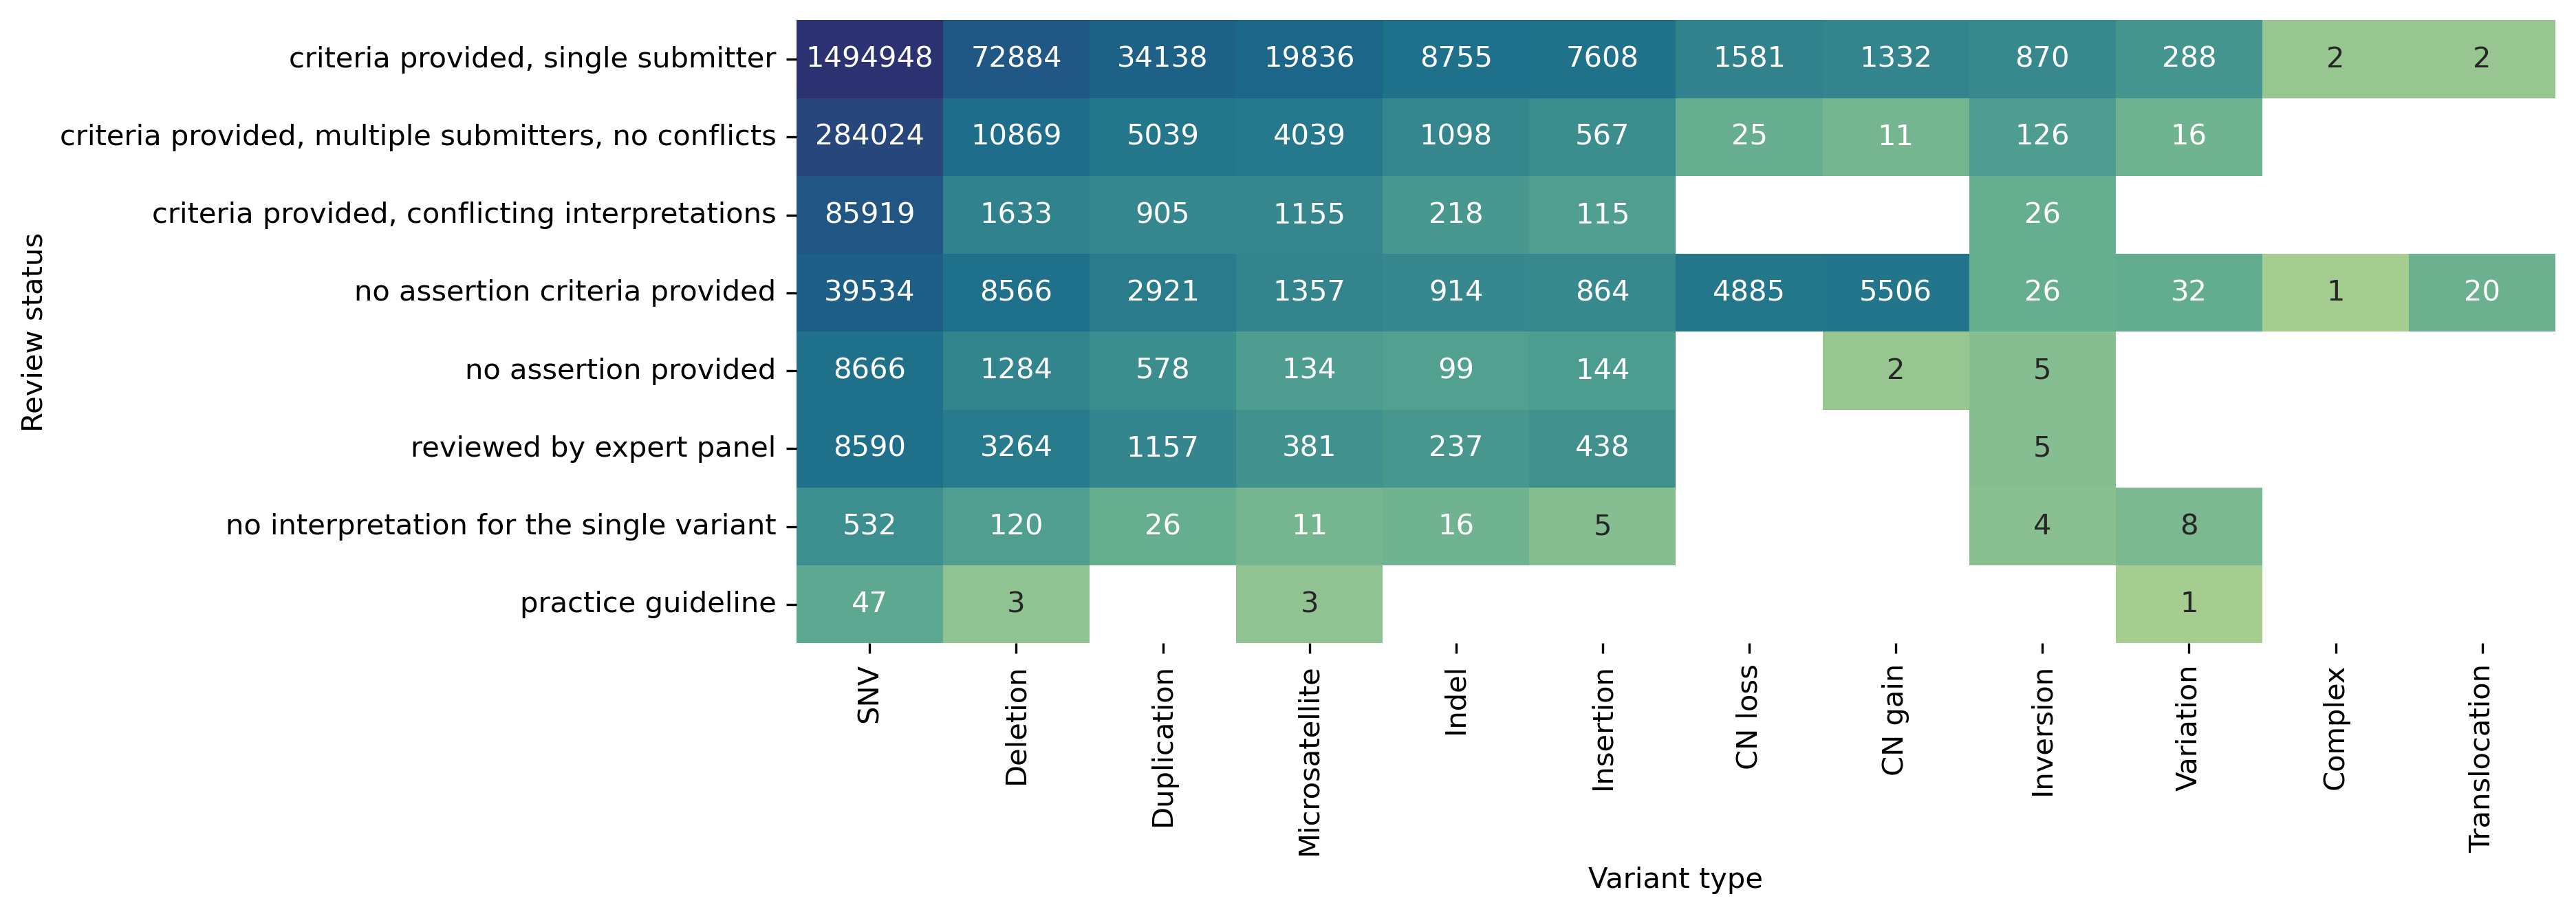

In [14]:
fig, ax = plt.subplots(1,1,figsize=(11, 4))
sns.heatmap(sum_table, annot=True, cmap='crest', cbar = False, fmt='d', norm=LogNorm(), ax = ax)
ax.set_xlabel('Variant type')
ax.set_ylabel('Review status');

In [17]:
conf_snps = vsum[(vsum['ReviewStatus'].isin([
    'criteria provided, multiple submitters, no conflicts',
    'reviewed by expert panel', 
    'practice guideline'])) & 
            (vsum['Type']=='single nucleotide variant')].dropna(subset=['GeneSymbol'])

In [18]:
conf_snps = conf_snps[~conf_snps['GeneSymbol'].str.contains(',')]
conf_snps['GeneSymbol_split'] = conf_snps['GeneSymbol'].str.split(';').apply(set).apply(list)
conf_snps_split = conf_snps.explode('GeneSymbol_split')
clinsig_per_gene = conf_snps_split.groupby('GeneSymbol_split')['ClinicalSignificance'].value_counts()

In [19]:
clinsig_per_gene = clinsig_per_gene.unstack(-1)

In [47]:
clinsig_per_gene

,Affects,Affects; association,Affects; risk factor,Benign,Benign/Likely benign,Benign/Likely benign; association,Benign/Likely benign; drug response,Benign/Likely benign; drug response; other,Benign/Likely benign; other,Benign/Likely benign; other; risk factor,...,no interpretation for the single variant,not provided,other,protective,protective; risk factor,risk factor,total,plp,vus,blb
GeneSymbol_split,,,,,,,,,,,,,,,,,,,,,
A2M,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
A2ML1,0,0,0,44,54,0,0,0,0,0,...,0,0,0,0,0,0,281,0,115,166
A4GALT,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,1,1
AAAS,0,0,0,7,6,0,0,0,0,0,...,0,0,0,0,0,0,35,10,12,13
AAGAB,0,0,0,5,0,0,0,0,0,0,...,0,0,0,0,0,0,8,2,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZP3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
ZPBP,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
ZRS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [20]:
clinsig_per_gene['total'] = clinsig_per_gene.sum(1)
clinsig_per_gene['plp'] = clinsig_per_gene[['Pathogenic', 
                                            'Pathogenic/Likely pathogenic', 
                                            'Likely pathogenic', 
                                            'Pathogenic; drug response', 
                                            'Likely pathogenic/Likely risk allele', 
                                            'Likely pathogenic; drug response']].sum(1)

clinsig_per_gene['vus'] = clinsig_per_gene[['Uncertain significance', 
                                            'Uncertain significance/Uncertain risk allele', 
                                            'Uncertain significance; other']].sum(1)

clinsig_per_gene['blb'] = clinsig_per_gene[['Likely benign', 'Benign/Likely benign', 'Benign']].sum(1)


In [201]:
var2gene_sum = clinsig_per_gene[['plp', 'vus', 'blb', 'total']].reset_index().rename(columns={'GeneSymbol_split': 'gene'})

In [202]:
var2gene_sum = var2gene_sum.merge(pinfo[['preferred_name', 'protein_size']], left_on='gene', right_on='preferred_name')

In [220]:
degrees = ppi[ppi.experiments > 900]['preferred_name1'].value_counts().to_frame(name='degrees900')
var2gene_sum = var2gene_sum.merge(degrees, left_on = 'gene', right_index=True, how='left')
var2gene_sum['degrees900'] = var2gene_sum['degrees900'].fillna(0)

Text(0, 0.5, '# ClinVar variants / gene length')

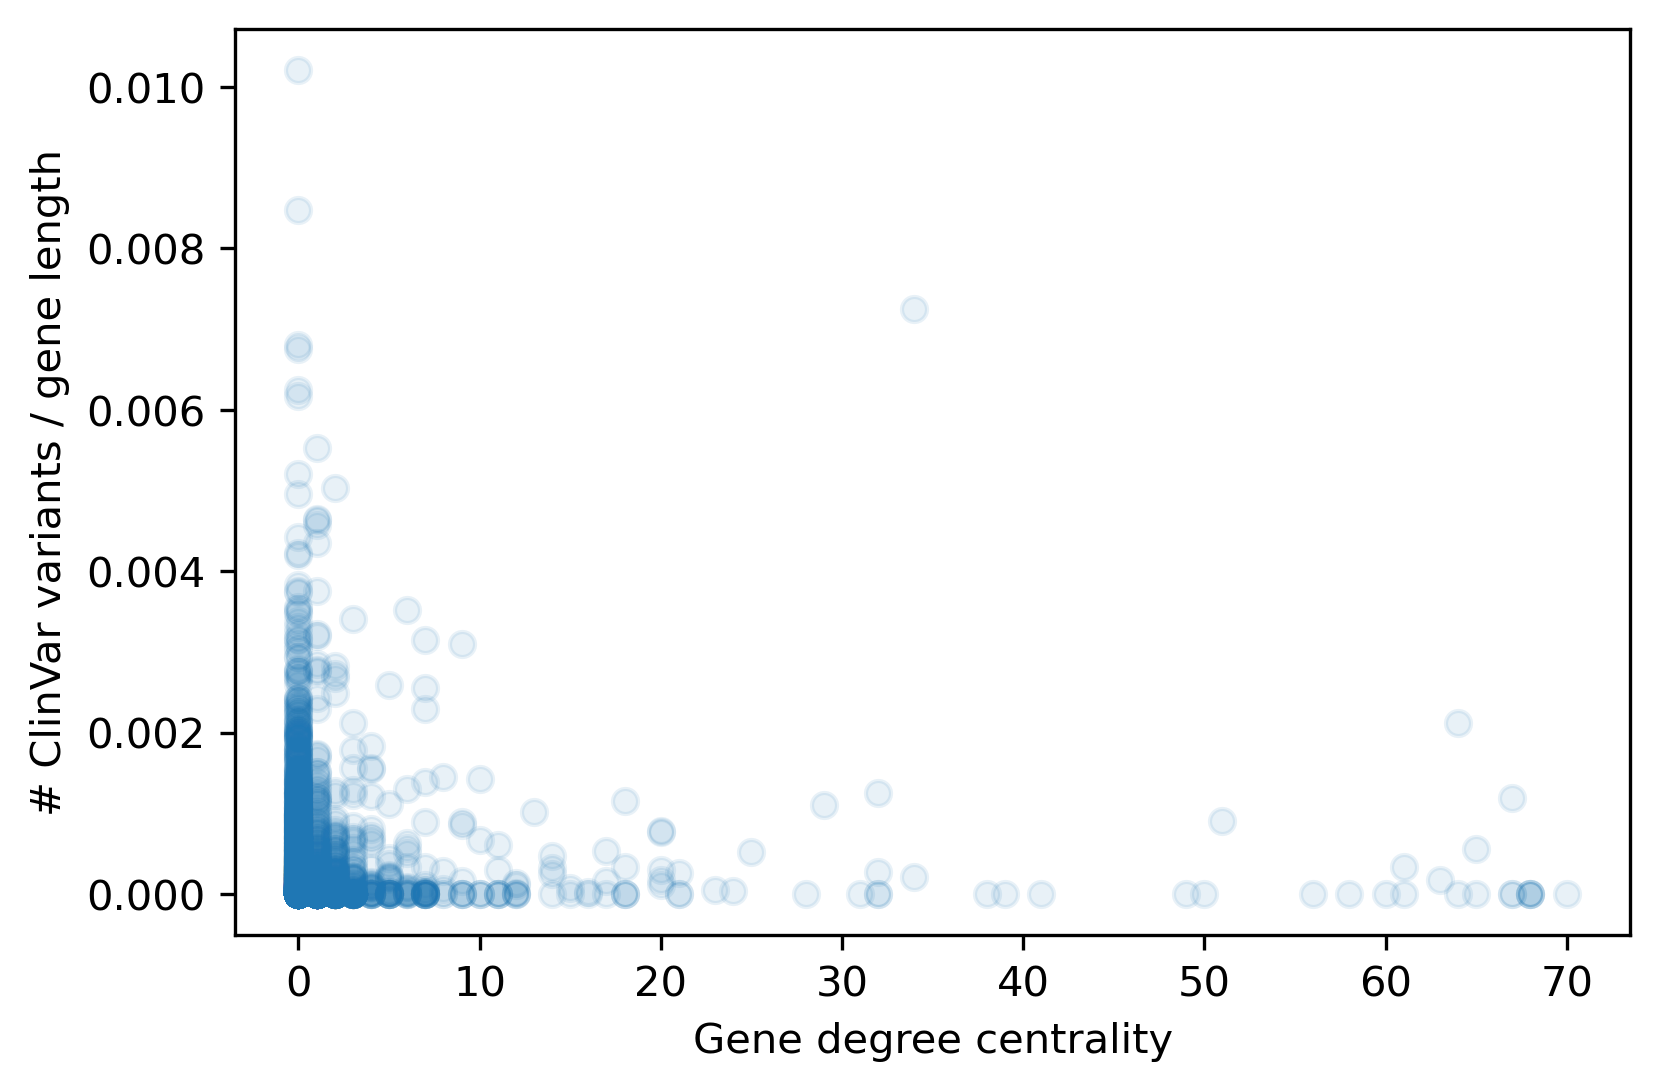

In [221]:
fig, ax = plt.subplots(1,1,figsize=(6,4)) 

ax.scatter(var2gene_sum['degrees900'], 
           var2gene_sum['plp']/var2gene_sum['total']/var2gene_sum['protein_size'], 
           alpha = 0.1)
ax.set_xlabel('Gene degree centrality')
ax.set_ylabel('# ClinVar variants / gene length')

2.5149700598802394
0.21830985915492956


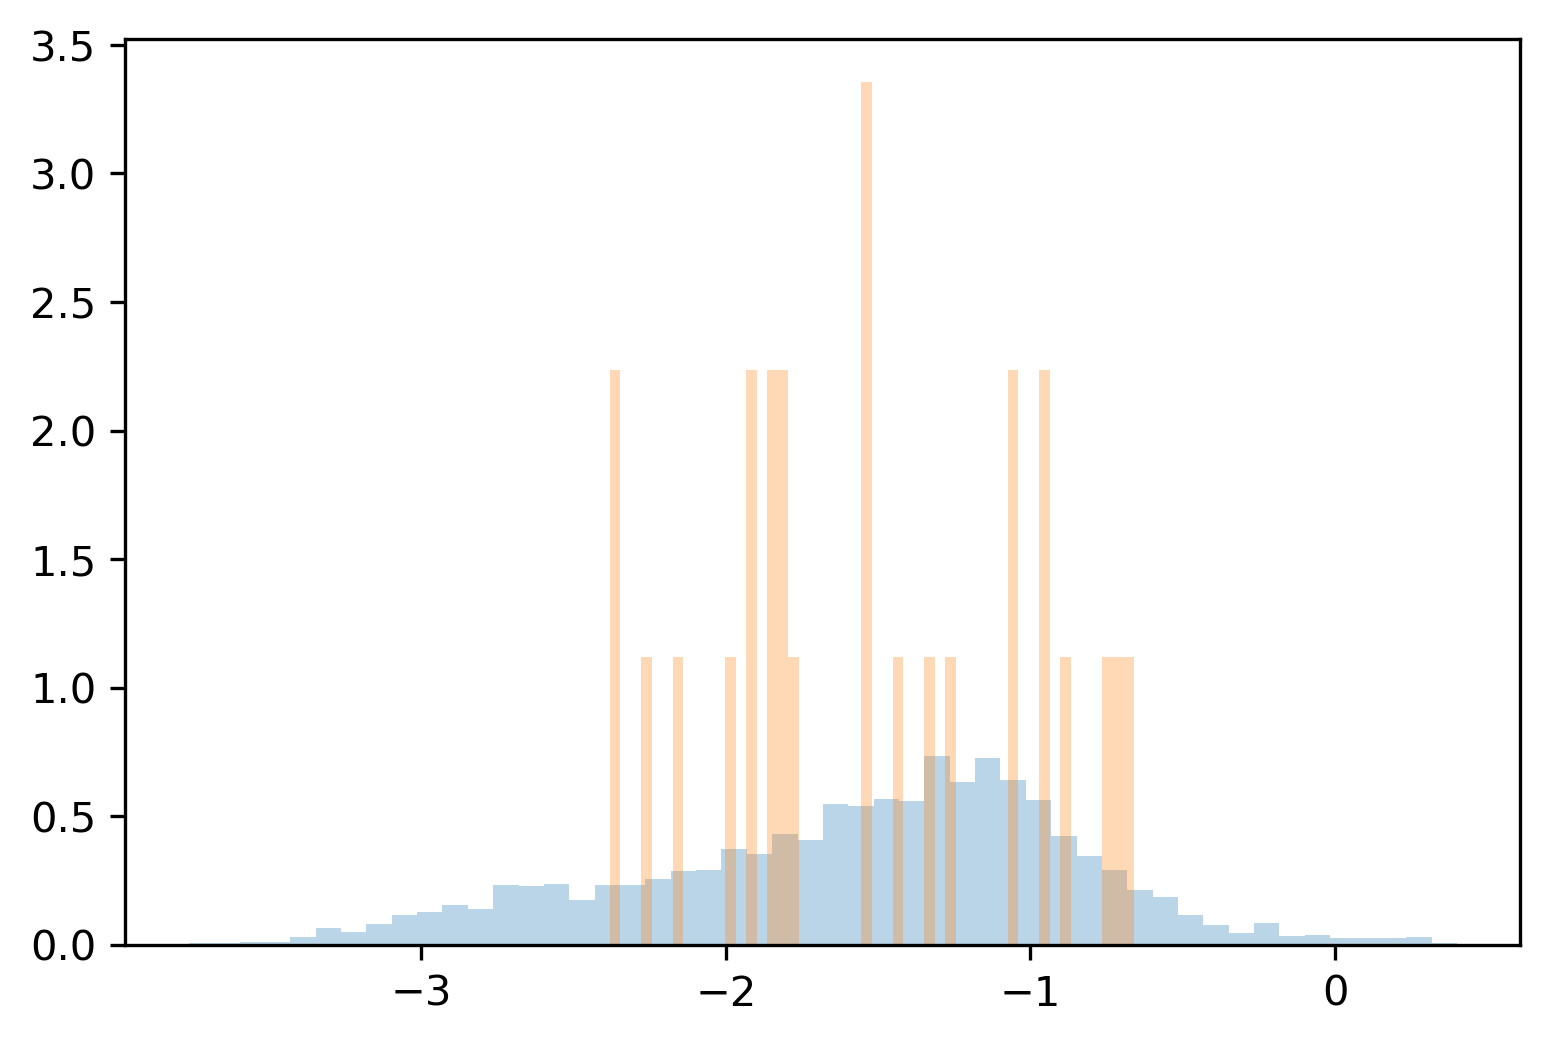

In [217]:
bins = [0, 100, np.inf]

for l,r in zip(bins[:-1], bins[1:]):
    df = var2gene_sum[var2gene_sum['degrees750'].between(l,r)]
    print((df['total']/df['protein_size']).max())
    plt.hist(np.log10(df['total']/df['protein_size']), bins=50, density=True, alpha=0.3);

Text(0, 0.5, 'Gene length-normalized percent P/LP ')

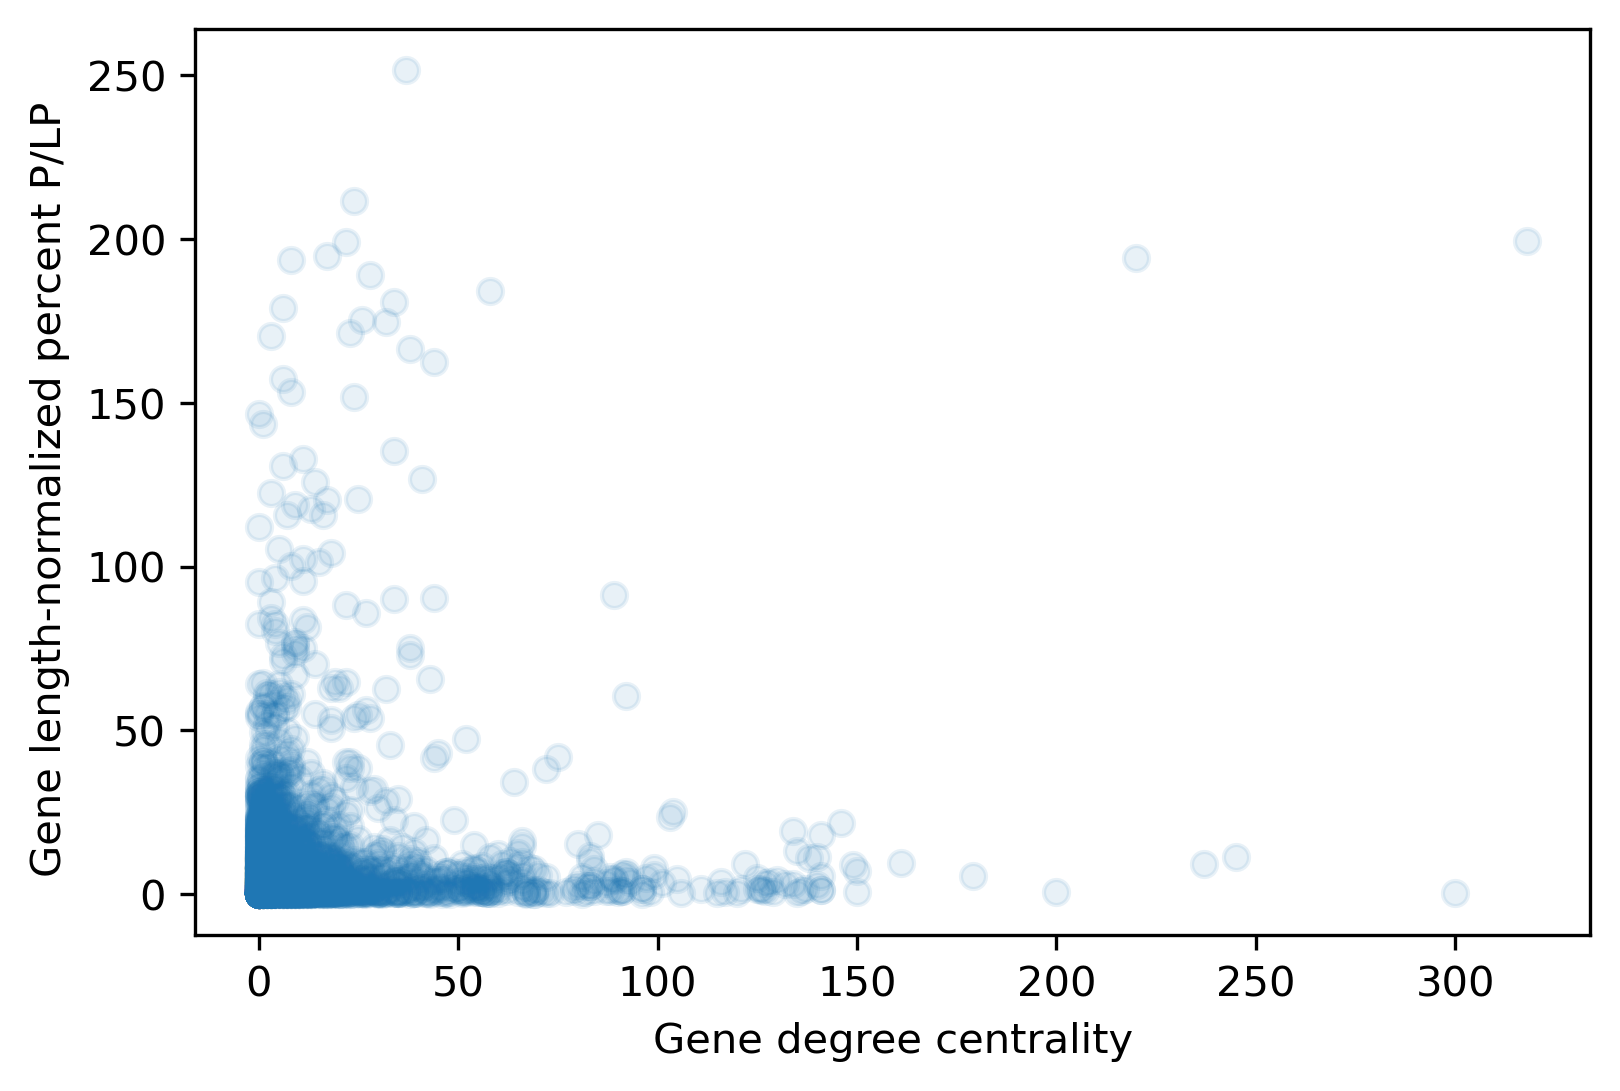

In [106]:
fig, ax = plt.subplots(1,1,figsize=(6,4)) 

ax.scatter(var2gene_sum['degrees400'], 
           var2gene_sum['total']/var2gene_sum['protein_size'] * 100, 
           alpha = 0.1)
ax.set_xlabel('Gene degree centrality')
ax.set_ylabel('Gene length-normalized percent P/LP ')